# Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tld
!pip install pandas==1.3.4

     |████████████████████████████████| 412 kB 16.3 MB/s 
     |████████████████████████████████| 11.3 MB 14.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
# Imports you may need
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from tld import get_tld
from ast import literal_eval
from os import listdir

# Creating a new database and saving it on the drive

The first step is to process the data we already have (i.e. all the sport quotes) to extract the media. To do so, we iterate through every year by chunk to avoid overflowding the memory. Then for each quote, we only keep the quoteID, the speaker ID and the urls. We explode the url and retrieve the domain name to obtain the media and save the file. Therefore we end up with a csv for each year with one line for each combination of quote and media.

This files will be the basis of the rest of the analysis.

In [ ]:
#Creating new files with one line per combination quote/media who quoted it
year = '2020'
incre = 0     # Number of iterations 
nlines = 0    # Number of lines

for chunk in pd.read_csv('/content/drive/MyDrive/ada-sports-quotes/sport-quotes-' + year + '.csv.bz2', compression='bz2', usecols=['quoteID','qids','urls'], converters={'urls': literal_eval, 'qids': literal_eval}, chunksize=100000):
  incre += 1
  sources = [] # Temporary vector to store the medias
  print(incre) # Just to check that everything works as the loop is quite long
  temp = chunk.explode('urls')
  temp = temp.explode('qids').drop_duplicates(['quoteID','urls']) # if a quote ID is twice cited in the same article, drop it
  for url in temp.urls:
    nlines += 1
    res = get_tld(url, as_object=True)
    sources.append(res.domain) # Recover all the medias in the chunk
  temp['media'] = sources
  temp.drop(columns='urls',inplace=True)
  if incre == 1:
    quote_per_media = temp
  else:
    quote_per_media = quote_per_media.append(temp)
print(nlines)
quote_per_media.to_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
14958282


# Studying the medias

Now that we have preprocessed the files to suit our need, we can use them to find out which medias are publishing most of the sport quotes. Then we will keep the 30 biggest to study their tendancy to publish quotes from political speakers. Finally, we will have a look at how the media's tendancy evolves through time.

## Ranking them

First, let's rank them in terms of number of quotes. To do so we will go through each year file generated, extract the number of quotes for each media and sum the results over the years to obtain the score from 2015 to 2020.

In [ ]:
# Obtaining the ranking of the biggest medias
ranking = pd.DataFrame()
years = ['2015','2016','2017','2018','2019','2020']

for year in years:
  quote_per_media = pd.read_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2') # Loading a year
  rank = quote_per_media.media.value_counts() 

  ranking = ranking.add(pd.DataFrame(rank), fill_value=0) # Adding the results year after year

ranking.sort_values('media',ascending=False, inplace=True)
ranking.head(5)

,media
msn,2489333.0
yahoo,2113850.0
eurosport,1068290.0
nbcsports,888715.0
nydailynews,680161.0


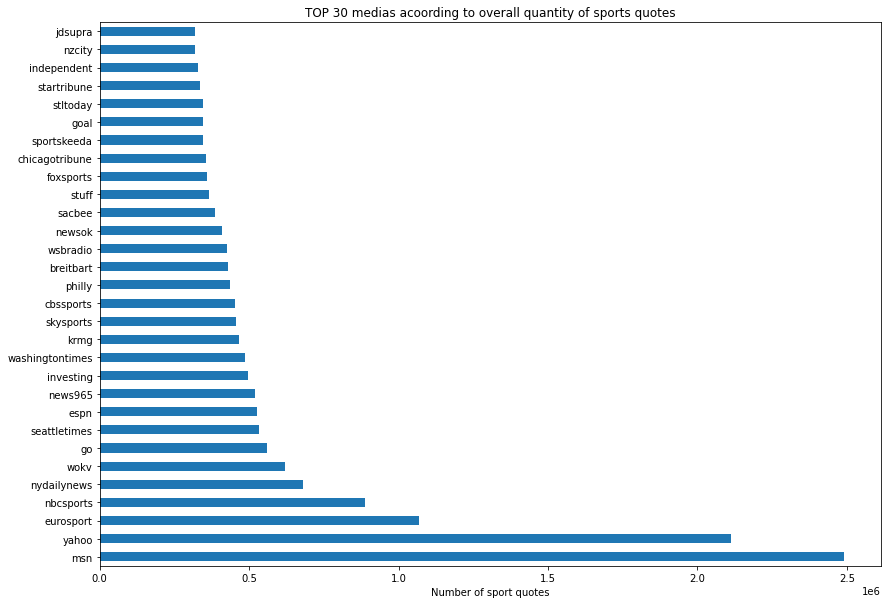

In [ ]:
# Plot
ranking[0:30].media.plot.barh(figsize=(14,10))
plt.xlabel('Number of sport quotes')
plt.title('TOP 30 medias acoording to overall quantity of sports quotes');
plt.savefig('/content/drive/MyDrive/ADA/ranking.png')

## Looking at the proportion of political speakers

Now that we have this ranking, we can have a look at the proportion of political speakers in each of the TOP 30 medias. This is done by checking if the speaker, identified by his wikidata ID, is affiliated to a political party or not.

In [ ]:
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

In [ ]:
vgrouped = pd.DataFrame() # DataFrame with the sum of the count of each type of speaker over the years
vgrouped_percent = pd.DataFrame() # DataFrame with the percentage of each type of speaker for each year the years

for year in years:
  quote_per_media = pd.read_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2')

  # match the speaker_attributes dataset
  speakers = speaker_attributes[speaker_attributes['id'].isin(quote_per_media.qids)]

  # Removing speakers without any known party (i.e. with 'party' == None)
  politicians = speakers[~(speakers['party'].isna())]

  # Attribution of a speaker type
  quote_per_media['Speaker type'] = quote_per_media.qids
  quote_per_media['Speaker type'].loc[quote_per_media.qids.isin(speakers.id)] = 'others'
  quote_per_media['Speaker type'].loc[quote_per_media.qids.isin(politicians.id)] = 'politics'
  quote_per_media = quote_per_media[quote_per_media['Speaker type'].isin(['others','politics'])]

  # Only keeping the quotes from the TOP 30
  quotes_in_main_media = quote_per_media[quote_per_media.media.isin(ranking[0:30].index)] 

  # Grouping by media and speaker type to obtain a df with media as item and count of each speaker type in columns
  grouped = quotes_in_main_media.groupby(['media','Speaker type']).count().quoteID
  grouped = grouped.unstack()
  grouped_percent = grouped.divide(grouped.sum(axis=1),axis=0)*100
  vgrouped_percent = vgrouped_percent.join(grouped_percent.politics,rsuffix=year, how='outer')
  vgrouped = vgrouped.add(grouped,fill_value=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
vgrouped.head(5)

Speaker type,others,politics
media,,
breitbart,251974.0,60207.0
cbssports,361441.0,14231.0
chicagotribune,243036.0,21593.0
espn,404510.0,15566.0
eurosport,771500.0,30729.0


In [ ]:
vgrouped_percent.head(5)

,politics,politics2016,politics2017,politics2018,politics2019,politics2020
media,,,,,,
breitbart,33.396716,20.841378,28.309508,17.161791,9.976587,13.277035
cbssports,4.009512,4.649620,5.292903,3.596777,2.466675,3.996541
chicagotribune,6.957664,8.657533,9.135541,7.177795,5.000000,11.764706
espn,5.172775,3.397820,3.879700,3.058334,4.159221,6.608358
eurosport,3.469435,4.618510,5.678588,3.067205,2.167498,6.084856


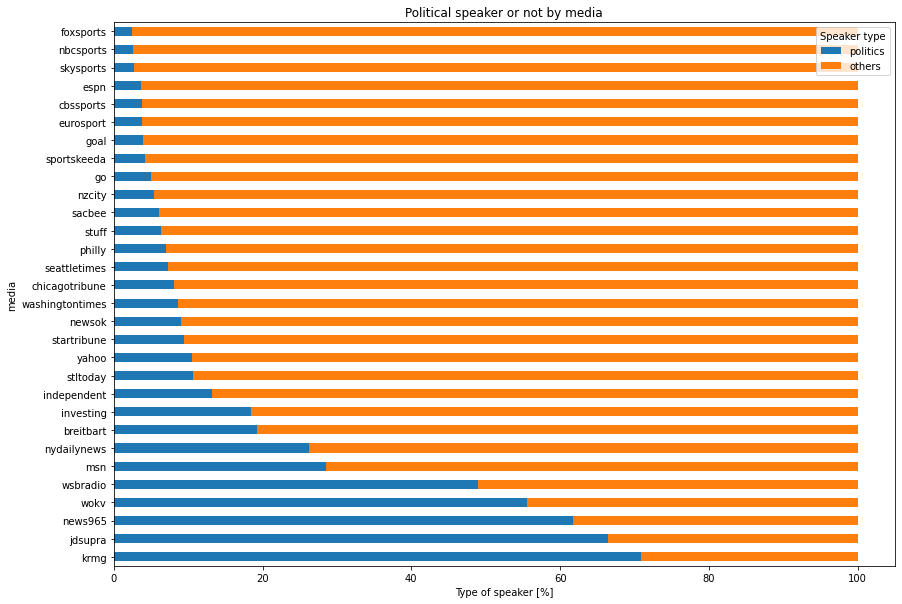

In [ ]:
overall_percent = vgrouped.divide(vgrouped.sum(axis=1),axis=0)*100
overall_percent.sort_values('politics', ascending=False, inplace=True)

# Plot
overall_percent[['politics','others']].plot.barh(sort_columns=True, stacked=True, figsize=(14,10))
plt.xlabel('Type of speaker [%]')
plt.title('Political speaker or not by media');
plt.savefig('/content/drive/MyDrive/ADA/Political_speakers_by_media.png')

## Studying this proportion through time

Now that we have clearly identified important differences between the different medias in terms of speaker proportions, let's have a look at the stability of these values through time. To do so, we first have a look at the standard deviation of the percentage for each media over the years. 

Afterwards, we have a closer look at was is going on through the years for the most unstable medias.

In [ ]:
temp = pd.DataFrame()
temp[years] = vgrouped_percent[vgrouped_percent.columns] # Renaming columns
standard_dev = temp.std(axis=1)
selection = temp[temp.std(axis=1) > 10] # Selecting only the medias with more than 10 STD

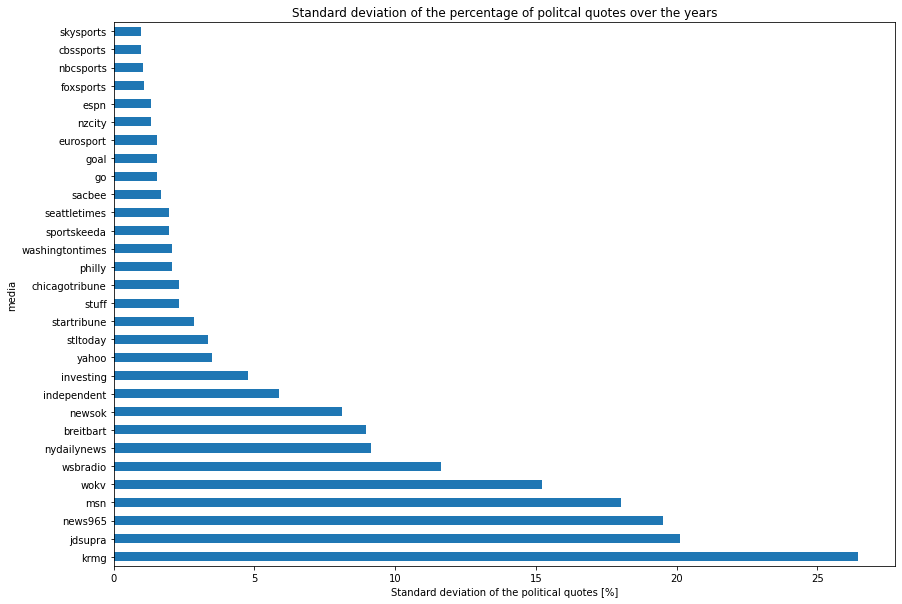

In [ ]:
standard_dev.sort_values(ascending=False, inplace=True)

# Plot
standard_dev.plot.barh(sort_columns=True, stacked=True, figsize=(14,10))
plt.xlabel('Standard deviation of the political quotes [%]')
plt.title('Standard deviation of the percentage of politcal quotes over the years');
plt.savefig('/content/drive/MyDrive/ADA/STD.png')

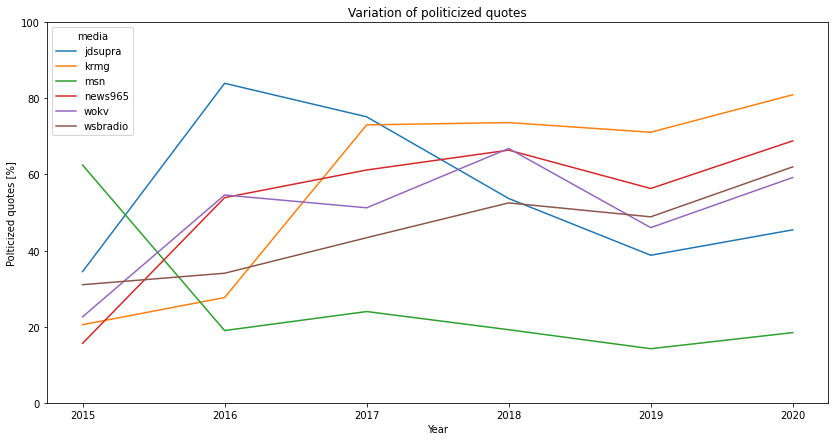

In [ ]:
selection.transpose().plot.line(sort_columns=True,figsize=[14,7],ylim=(0,100))
plt.xlabel('Year')
plt.ylabel('Polticized quotes [%]')
plt.title('Variation of politicized quotes')
plt.savefig('/content/drive/MyDrive/ADA/variation.png')

# All the quotes through time

In this section, we simply want to have a look at the date of publication of each sport quotes pronounced by political speaker. The idea behind it is to have a look at the evolution of this number through time and see if patterns appear such as during the US presidential campaigns.

2020  :  16470
2019  :  52910
2018  :  84907
2017  :  99647
2016  :  48014
2015  :  65212


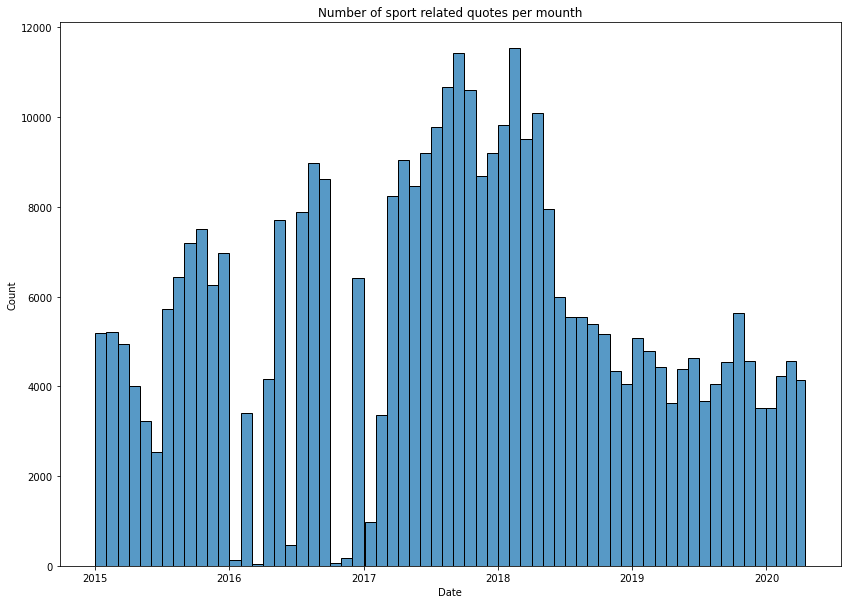

In [ ]:
plt.figure(figsize=[14,10])
years = ['2020','2019','2018','2017','2016','2015']
for year in years:
  test = pd.read_csv('/content/drive/MyDrive/quotes_by_politicians/quotes_by_politicians_' + year + '.csv')
  test['date'] = pd.to_datetime(test.quoteID.str[0:10])
  #plt.figure()
  if test.date[0].year == 2020:
    sns.histplot(test.date, bins = 4);
  else:
    sns.histplot(test.date, bins = 12);
  print(test.date[0].year, ' : ', test.shape[0])
plt.xlabel('Date')
plt.title('Number of sport related quotes per mounth')
plt.savefig('/content/drive/MyDrive/ADA/mounth frequency.png')